In [36]:
import os
import itertools 
import numpy as np
import cv2
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier #
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
plt.style.use("seaborn-whitegrid")
plt.rc("figure",autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold",titlesize=14, titlepad=10)

In [3]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0).squeeze().map(str) # call squeeze to ensure you have a Series
path = os.getcwd() + '\images\image_train'
#Create a column with the name of the picture
X['image_name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image_path'] = path + r'\image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
image_size = (50,50)
path_list = list(X['image_path'][:30000])
index_list = list(X[:30000].index)
label_list = list(y[:30000])
images_tuples = []
for path, idx, label in zip(path_list,index_list,label_list):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_gray_red = cv2.resize(img_gray, dsize = (image_size),interpolation = cv2.INTER_LANCZOS4 )
    images_tuples.append((idx,label,img_gray_red))

In [4]:
column_names = ['index','label']
for pixel in range(image_size[0]*image_size[1]):
    column_names.append('pixel'+str(pixel+1))
images_list = []
for image in images_tuples:
    idx,label,img = image
    pixel_list = [idx,label]###
    for row_pixels in img:
        for pixel in row_pixels:
            pixel_list.append(pixel)
    images_list.append(pixel_list)
rakuten_images = pd.DataFrame(images_list,columns=column_names)

In [5]:
rakuten_images.to_csv('rakuten_reduced_all_images310821.csv',index_label='idx')
rakuten_reduced_images = pd.read_csv('rakuten_reduced_all_images310821.csv',index_col='index')
rakuten_reduced_images.drop(columns=['idx'],inplace=True)

In [6]:
# definition of models input datas
target = rakuten_images['label']
data = rakuten_images.drop('label',1)
pca = PCA(n_components = 30)
X_train = data[:20000]
X_test = data[20000:]
X_train_scaled = X_train /255
X_test_scaled = X_test /255
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
y_train = y[X_train.index]
y_test = y[X_test.index]

In [7]:
def score_model(model, X_t=X_train, y_t=y_train, X_te=X_test, y_te=y_test):
    model.fit(X_t,y_t)
    preds=model.predict(X_te)
    return f1_score (y_te,preds,average='weighted')

def conf_matx(model, y_te=y_test, X_te=X_test):
    #Variable target avec les labels organisées:
    y_organised = ['10','2280','2403','2705','2522',
               '40','50','2905','2462','60',
               '1280','1281','1300','1180','1140','1160',
               '1320','1560',
               '2582','2583','2585','1302','2220',
               '1920','2060',
               '1301','1940']
        
    preds=model.predict(X_te)
    cnf_matrix = metrics.confusion_matrix(y_test,preds,labels=y_organised)
    y_organised
    pond_matrix = []
    for line in cnf_matrix:
        pond_line = []
        for cell in line:
            pond_line.append(round(cell/sum(line),2))
        pond_matrix.append(pond_line)
    cnf_matrix = np.array(pond_matrix)
    classes = y_organised
    plt.figure(figsize=(15,15))
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
    plt.ylabel('Y TRUE')
    plt.xlabel(' PREDICTION')
    plt.show()

### INPUT 
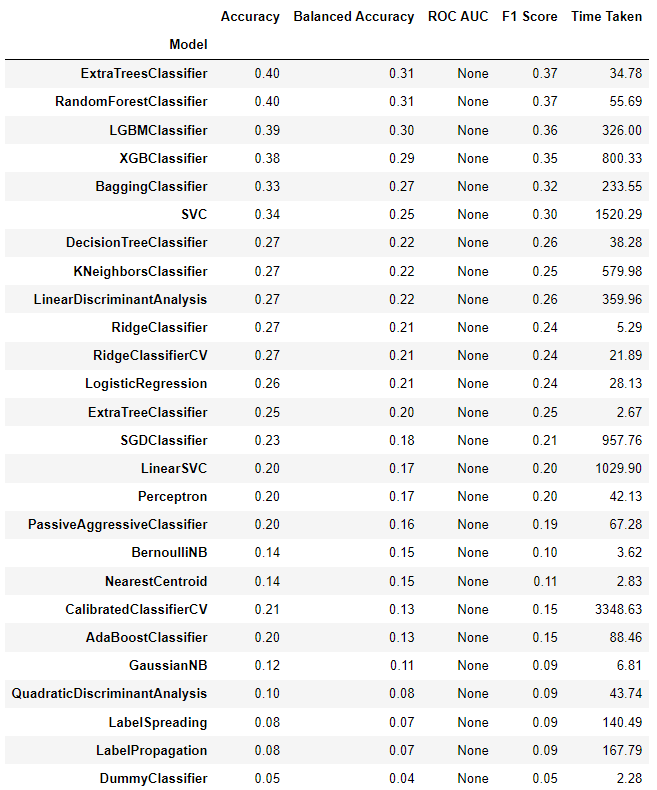

### Modèles de RANDOM FOREST

In [ ]:
# boucle optimization SANS utilisation prétraitement PCA

In [13]:
clf_rfo  = RandomForestClassifier(random_state=42) #max_iter=1000

params_rfo = { 
    'n_estimators': [200, 500,1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
    #'oob_score' : [False,True]
    }
randomcv_rfo = RandomizedSearchCV(clf_rfo,
                       params_rfo,
                       scoring='accuracy',
                       cv=3)    

In [14]:
randomcv_rfo.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 500, 1000]},
                   scoring='accuracy')

In [15]:
randomcv_rfo.best_params_

{'n_estimators': 200,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

In [16]:
pd.DataFrame(randomcv_rfo.cv_results_)[['params', 'mean_test_score', 'std_test_score']]  ###

,params,mean_test_score,std_test_score
0,"{'n_estimators': 1000, 'max_features': 'sqrt',...",0.25165,0.003859
1,"{'n_estimators': 500, 'max_features': 'auto', ...",0.31160,0.003798
2,"{'n_estimators': 500, 'max_features': 'sqrt', ...",0.28260,0.002980
3,"{'n_estimators': 1000, 'max_features': 'sqrt',...",0.25090,0.001654
4,"{'n_estimators': 500, 'max_features': 'auto', ...",0.25145,0.003669
5,"{'n_estimators': 1000, 'max_features': 'auto',...",0.25090,0.001654
6,"{'n_estimators': 200, 'max_features': 'auto', ...",0.31665,0.001369
7,"{'n_estimators': 1000, 'max_features': 'auto',...",0.28135,0.002718
8,"{'n_estimators': 500, 'max_features': 'sqrt', ...",0.25145,0.003669
9,"{'n_estimators': 200, 'max_features': 'auto', ...",0.25100,0.001884


In [17]:
clf_rfo_end=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='entropy')

In [18]:
clf_rfo_end.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=200,
                       random_state=42)

In [20]:
score_model(clf_rfo_end, X_train, y_train, X_test, y_test)

0.2629658857331852

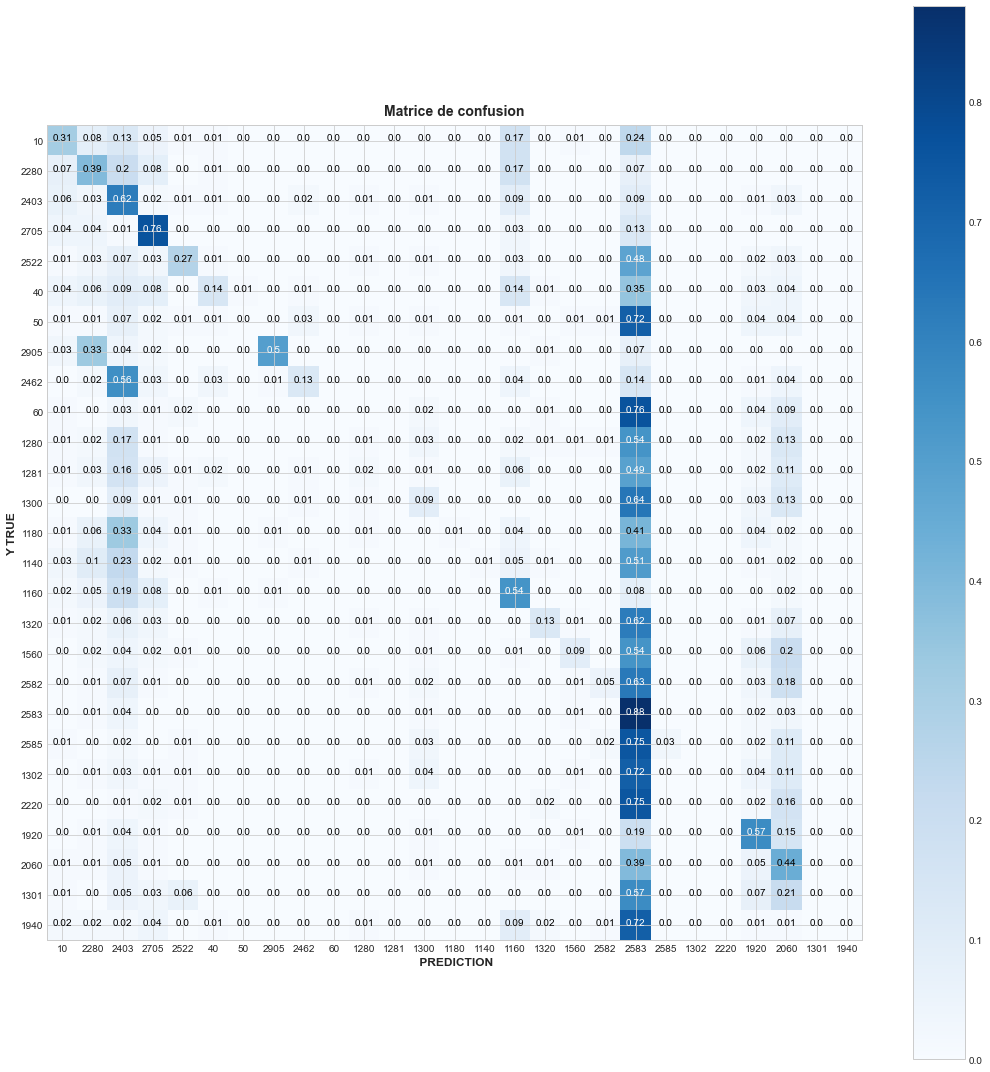

In [21]:
conf_matx(clf_rfo_end,y_test,X_test)

In [ ]:
# boucle optimization AVEC utilisation prétraitement PCA

In [23]:
clf_rfo_pca  = RandomForestClassifier(random_state=42)
gridcv_rfo_pca = RandomizedSearchCV(clf_rfo_pca,
                       params_rfo,
                       scoring='accuracy',
                       cv=3)    

In [24]:
gridcv_rfo_pca.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 500, 1000]},
                   scoring='accuracy')

In [26]:
gridcv_rfo_pca.best_params_

{'n_estimators': 1000,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

In [27]:
clf_rf_pca_end=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 1000, max_depth=8, criterion='entropy')

In [28]:
clf_rf_pca_end.fit(X_train_pca, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=1000,
                       random_state=42)

In [29]:
score_model(clf_rf_pca_end, X_train_pca, y_train, X_test_pca, y_test)

0.21888166972457898

In [ ]:
# résult is not interesting with PCA preprocessing

In [ ]:
conf_matx(clf_rf_pca_end,X_test_pca,y_test)

### Modèle extra_trees Classifiers

In [ ]:
# boucle optimization SANS utilisation prétraitement PCA

In [39]:
clf_ETC  = ExtraTreesClassifier(random_state=42) #max_iter=1000

params_ETC = { 
    'n_estimators': [200, 500,1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
    #'bootstrap' : [False,True]
    }
randomcv_ETC = RandomizedSearchCV(clf_ETC,
                       params_ETC,
                       scoring='accuracy',
                       cv=3)    

In [40]:
randomcv_ETC.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 500, 1000]},
                   scoring='accuracy')

In [41]:
randomcv_ETC.best_params_

{'n_estimators': 1000,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'gini'}

In [42]:
clf_ETC_end=ExtraTreesClassifier(random_state=42, max_features='sqrt', n_estimators= 1000, max_depth=8, criterion='gini')

In [43]:
clf_ETC_end.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=8, max_features='sqrt', n_estimators=1000,
                     random_state=42)

In [44]:
score_model(clf_ETC_end, X_train, y_train, X_test, y_test)

0.23911740401887155

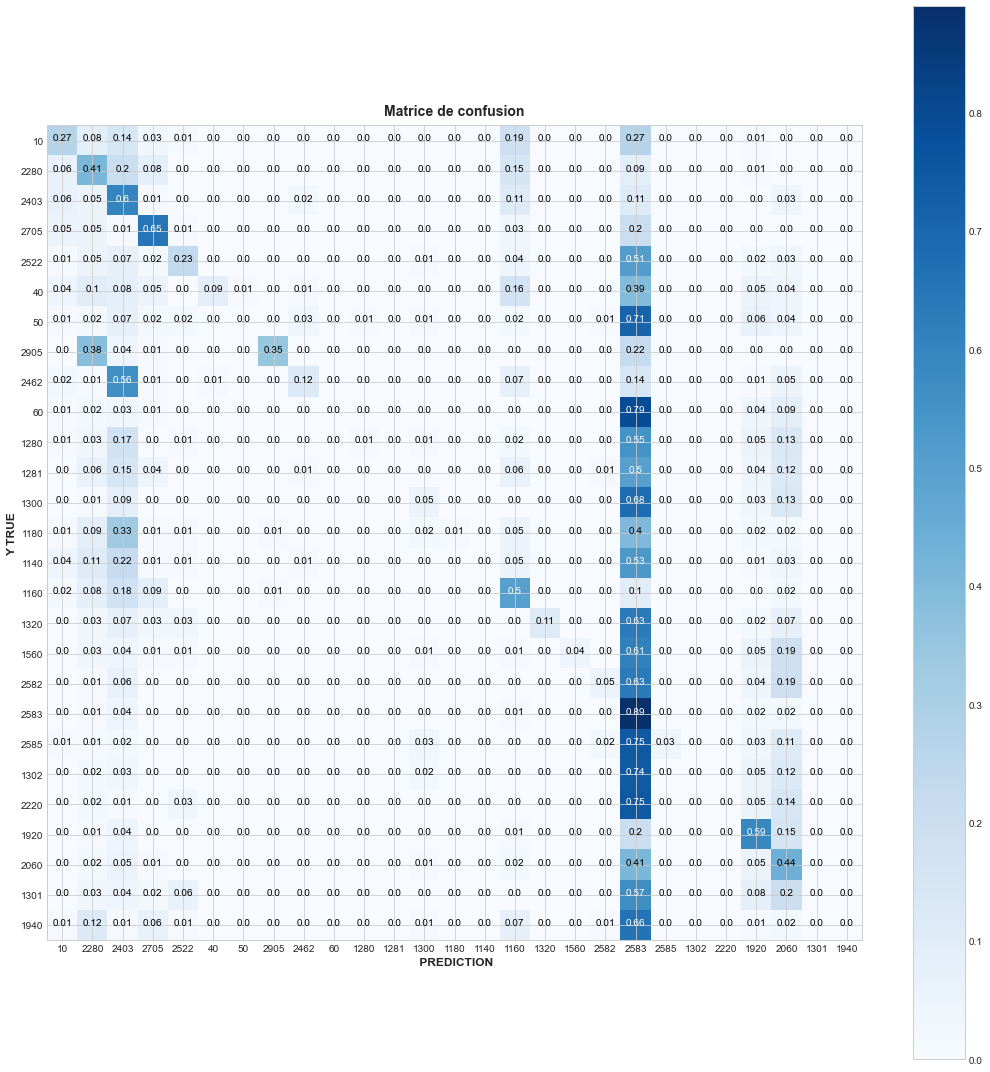

In [45]:
conf_matx(clf_ETC_end,y_test,X_test)

In [ ]:
# AUTRE TEST basé sur des paramètres d'une autre étude (arbitraire!)
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-faces-py

In [48]:
clf_ETC_other=ExtraTreesClassifier(random_state=42, n_estimators=1000,
                              max_features=128,
                              n_jobs=-1)

In [49]:
clf_ETC_other.fit(X_train, y_train)

ExtraTreesClassifier(max_features=128, n_estimators=1000, n_jobs=-1,
                     random_state=42)

In [50]:
score_model(clf_ETC_other, X_train, y_train, X_test, y_test)

0.38278426169683993

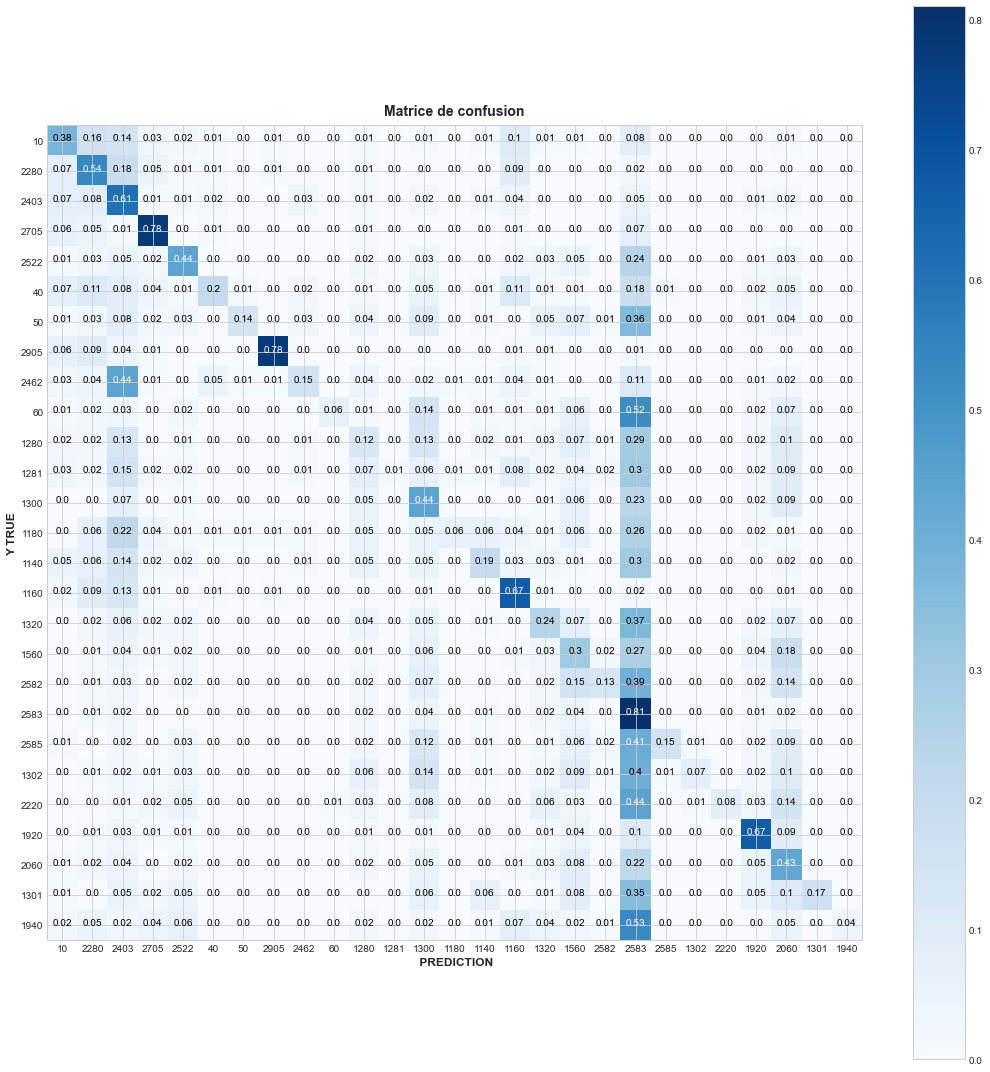

In [51]:
conf_matx(clf_ETC_other,y_test,X_test)

In [59]:
# check manual of f1 weighted score best ML model computer vision

In [60]:
y_pred=clf_ETC_other.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.38278426169683993